# Titanic Competition

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
%matplotlib inline

In [60]:
#ml imports
from sklearn import metrics
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
#pwd

In [4]:
#with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
#    zip_ref.extractall('C:\\Users\\SamPe\\Docs\\Data\\Titanic_Project\\kaggle_Titanic')

# Data Exploration

In [5]:
df = pd.read_csv('.\\Data\\train.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:xlabel='Survived', ylabel='count'>

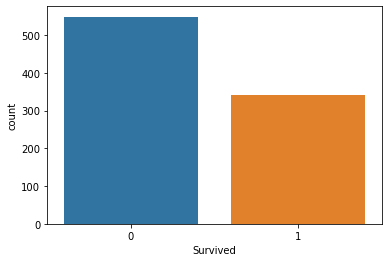

In [9]:
#survived is the label
#sibsp and parch can be combined to form a family metric
sns.countplot(data=df,x='Survived')

The labels are imbalanced, so we will focus more on precision and recall when we evaluate

In [10]:
#exploratory correlation plot

<AxesSubplot:>

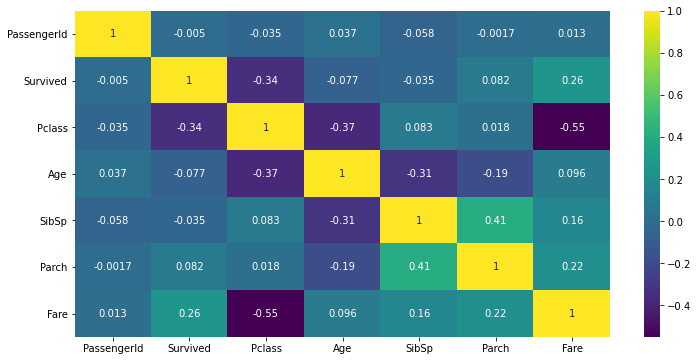

In [11]:
plt.figure(figsize=(12,6))
sns.heatmap(data=df.corr(),annot=True,cmap='viridis')

Pclass and Fare have significant correlation with the label of the numeric columns, Sex and Embarked are good candidates to explore among the other labels.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

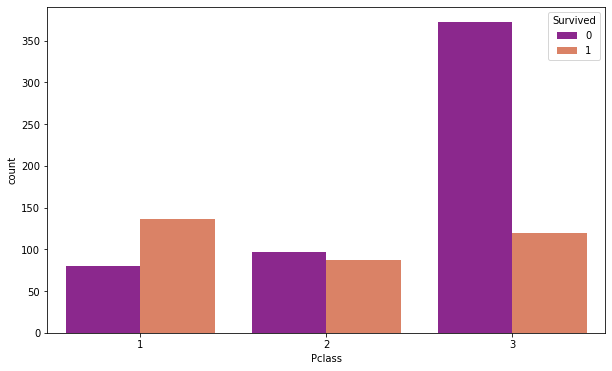

In [12]:
#Pclass
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Pclass',hue='Survived',palette='plasma')

Passengers in the first or second class were much more likely than third class passengers to survive

<Figure size 864x576 with 0 Axes>

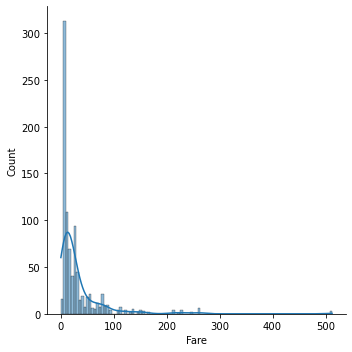

In [13]:
#Fare is strongly related to passenger class, so we will explore their relationship with each other as well
plt.figure(figsize=(12,8))
sns.displot(data=df, kind='hist',x='Fare',kde=True)

In [14]:
#Most values are under 100, and there are some outliers above that. I will find the value at the 10th percentile
#and adjust the outliers to that value because there is a significant jump from 20th to 10th percentile
df['Fare'].quantile(np.linspace(.1, 1, 9, 0), 'lower')

0.1     7.5500
0.2     7.8542
0.3     8.0500
0.4    10.5000
0.5    14.4542
0.6    21.6792
0.7    27.0000
0.8    39.6875
0.9    77.9583
Name: Fare, dtype: float64

In [15]:
len(df) * .1

89.10000000000001

In [16]:
#replaces fare to 90th perentile plus an arbitrary scalar adjustment so that they keep their positions but - 
#do not affect the distribution too heavily
def replace_fare(fare):
    if (fare > 77.9583):
        return 78 + (fare/10)
    else:
        return fare

In [17]:
df['Fare'] = df['Fare'].apply(lambda x: replace_fare(x))

In [18]:
#Fare is adjusted for outliers now
df['Fare'].describe()

count    891.000000
mean      26.919141
std       27.053551
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      129.232920
Name: Fare, dtype: float64

<Figure size 864x576 with 0 Axes>

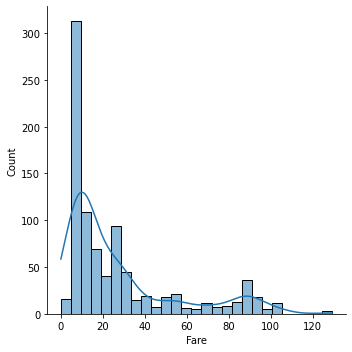

In [19]:
plt.figure(figsize=(12,8))
sns.displot(data=df, kind='hist',x='Fare',kde=True)

<AxesSubplot:xlabel='Sex', ylabel='count'>

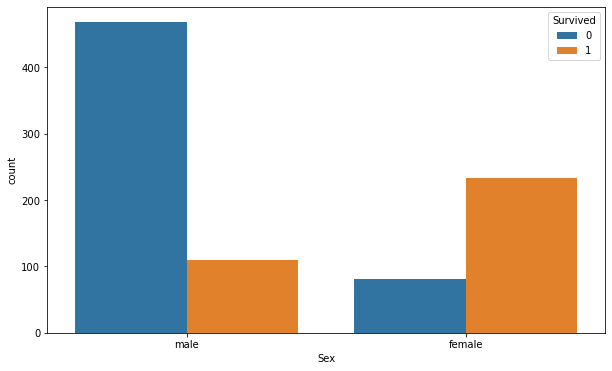

In [20]:
#exploring the relationship between Sex and the label
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Sex',hue='Survived')

We can see that Sex has a significant impact on the label

In [21]:
#exploring the relationship between embarked and the label
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='Embarked', ylabel='count'>

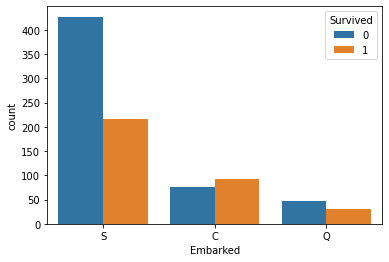

In [22]:
sns.countplot(data=df,x='Embarked',hue='Survived')

The embarked column also has significant impact on the label, with the 'C' port having a much greater chance of survival relative to the other two ports

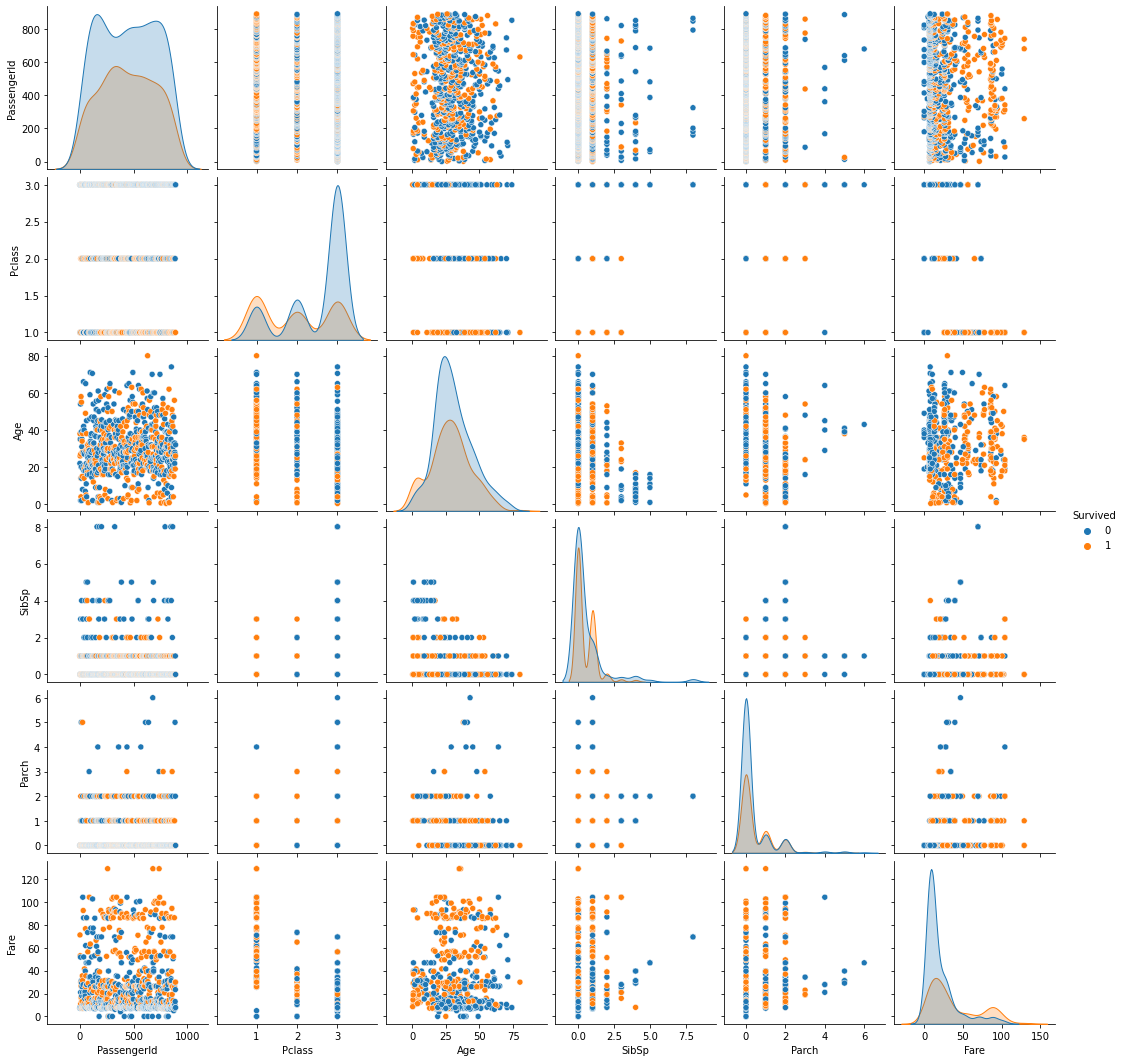

In [23]:
#explore variables relationships with each other
sns.pairplot(data=df,hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

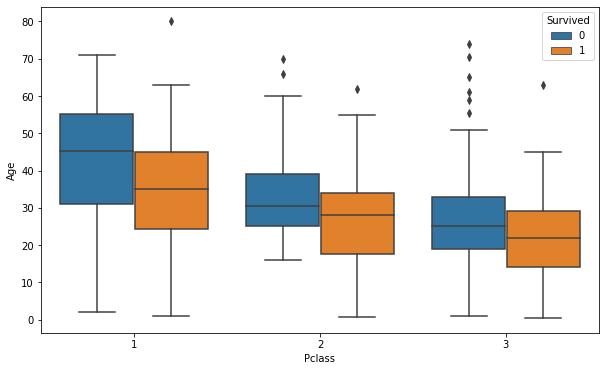

In [24]:
#We can see a relationship with age, class, and the label. Younger passengers, especially those in first -
#and second class survived. It also looks like a good amount of older passengers (40+) in first class survived as well.
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Pclass',y='Age',hue='Survived')

In [25]:
#Adjusting outliers in Age
df[(df['Age'] > 65) & (df['Pclass'] == 1) & (df['Survived'] == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,A23,S


In [26]:
#Reassigning ages that are outliers to be around the value of the upper quartile
#First Class survivor(s)
df.loc[df.PassengerId == 631, 'Age'] = 64

In [27]:
#Second class reassigning
#did not survive
df[(df['Age'] > 63) & (df['Pclass'] == 2) & (df['Survived'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5,NaN,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5,NaN,S


In [28]:
df.loc[df.PassengerId == 34, 'Age'] = 60
df.loc[df.PassengerId == 673, 'Age'] = 60

In [29]:
#survived
df[(df['Age'] > 57) & (df['Pclass'] == 2) & (df['Survived'] == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5,NaN,S


In [30]:
df.loc[df.PassengerId == 571, 'Age'] = 57

In [31]:
#third class did not survive
df[(df['Age'] > 54) & (df['Pclass'] == 3) & (df['Survived'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
94,95,0,3,"Coxon, Mr. Daniel",male,59.0,0,0,364500,7.2500,NaN,S
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S


In [32]:
#this is a better way to do the replacing
df.loc[(df.Pclass == 3) & (df.Survived == 0) & (df.Age > 54), 'Age'] = 54

In [33]:
#third class survived
df.loc[(df.Pclass == 3) & (df.Survived == 1) & (df.Age > 47), 'Age'] = 47

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

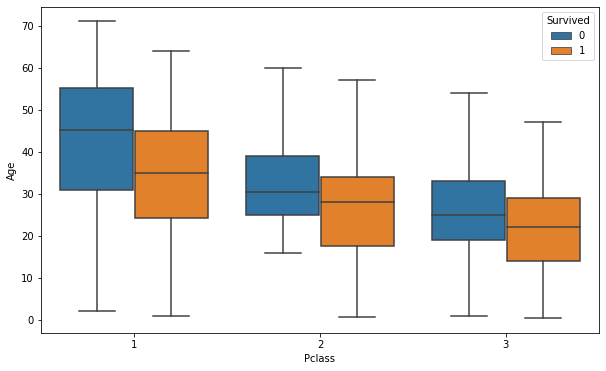

In [34]:
#No outliers now
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Pclass',y='Age',hue='Survived')

# Data Preprocessing & Feature Engineering
with outliers adjusted for, I should fill out missing data, convert categorical string variables to dummies, and remove or process repetitive or unnecessary features

In [35]:
#There are larges holes in the Age and Cabin columns
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

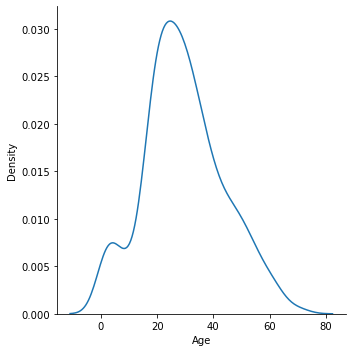

In [36]:
#Distribution of Age
sns.displot(data=df,x='Age',kind='kde')

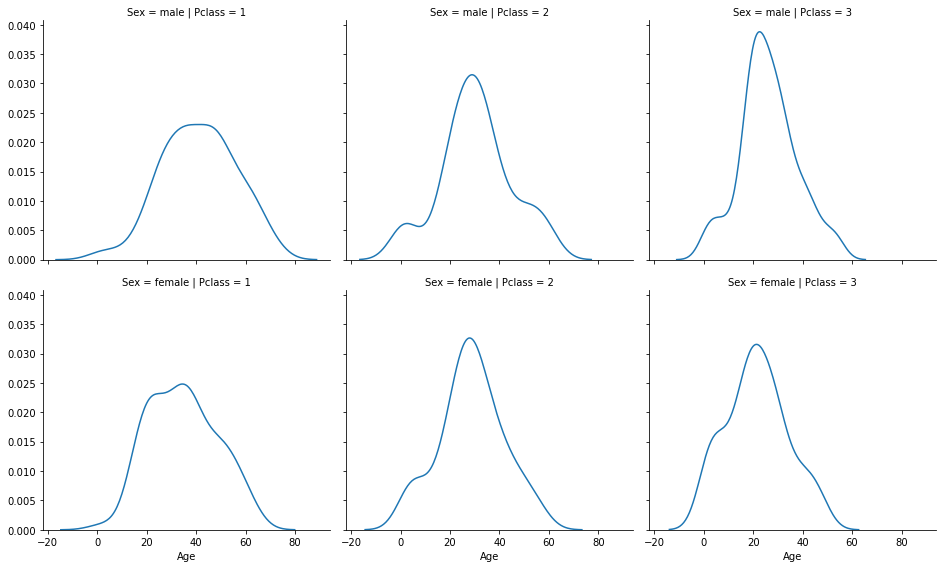

In [37]:
#Distribution of Age by class, it suggests that we should replace the missing ages based on other labels
g = sns.FacetGrid(data=df,col='Pclass',row='Sex',height=4.0,aspect=1.1)
g.map(sns.kdeplot,'Age')

In [38]:
#We can do a linear regression to predict the missing age values, but that will require creating dummies 
#of the categorical string variables we will use in the regression
#From the pairplot earlier, the family and class columns had the highest correlation with Age
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
#creating a family column that combines SibSp and Parch
df['Family']= df['SibSp'] + df['Parch']

In [40]:
df['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

In [41]:
df = pd.get_dummies(data=df, columns = ['Sex','Embarked'],drop_first=True)

In [42]:
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Family,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,1


## Linear Regression for Age imputation

In [77]:
#split dataframe into one without missing values, and one with
not_nadf = df.loc[df.Age.notna()]
na_df = df.loc[df.Age.isna()]

In [78]:
#dropping the labels not used for prediction for the missing values dataframe
not_nadf = not_nadf.drop(['PassengerId', 'Name', 'SibSp', 'Parch','Ticket','Cabin','Embarked_Q','Embarked_S',
            'Sex_male',],axis=1)
na_df = na_df.drop(['PassengerId', 'Name', 'SibSp', 'Parch','Ticket','Cabin','Age','Embarked_Q','Embarked_S',
            'Sex_male',],axis=1)

In [79]:
not_nadf.head()

,Survived,Pclass,Age,Fare,Family
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,1
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,1
4,0,3,35.0,8.0500,0


In [82]:
#store predictions and actual values
y_pred = []
y_true = []

In [84]:
#using k-fold cross validation for model validation
for train_index, test_index in kf.split(not_nadf):
    df_test = not_nadf.iloc[test_index]
    df_train = not_nadf.iloc[train_index]
    
    X_train = np.array(df_train[['Survived','Pclass','Fare','Family']]).reshape(-1, 4)     
    y_train = np.array(df_train['Age']).reshape(-1, 1)
    X_test = np.array(df_test[['Survived','Pclass','Fare','Family']]).reshape(-1, 4)  
    y_test = np.array(df_test['Age']).reshape(-1, 1)
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    y_pred.append(lm.predict(X_test)[0])
    y_true.append(y_test[0])    

In [87]:
print("Mean Square Error (Linear Regression): ", metrics.mean_squared_error(y_true, y_pred))
#print("Mean Square Error (Random Forest): ", metrics.mean_squared_error(y_pred_rf, y_true_rf))

Mean Square Error (Linear Regression):  182.96117501111598


In [66]:
#Linear Regression for Age
X=not_nadf.drop(['PassengerId', 'Name', 'SibSp', 'Parch','Ticket','Cabin','Age','Embarked_Q','Embarked_S',
            'Sex_male',],axis=1)
y=not_nadf['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
scaler = StandardScaler()

In [68]:
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-0.82127745, -0.25238954, -0.58422984, -0.63057157],
       [ 1.21761532, -0.25238954, -0.38159212,  0.73452697],
       [ 1.21761532, -0.25238954, -0.12609239,  0.0519777 ],
       [ 1.21761532, -1.44052519,  1.39985773, -0.63057157],
       [-0.82127745,  0.93574611, -0.81506063, -0.63057157],
       [ 1.21761532, -0.25238954,  0.25275204,  0.73452697],
       [ 1.21761532,  0.93574611, -0.48379201,  1.41707623],
       [ 1.21761532, -0.25238954, -0.23181642,  2.0996255 ],
       [-0.82127745,  0.93574611, -0.7641087 , -0.63057157],
       [-0.82127745,  0.93574611, -0.76307965, -0.63057157],
       [ 1.21761532, -1.44052519,  0.96638922,  0.0519777 ],
       [ 1.21761532, -0.25238954, -0.58422984, -0.63057157],
       [ 1.21761532, -1.44052519,  0.96638922,  0.0519777 ],
       [-0.82127745,  0.93574611, -0.7641087 , -0.63057157],
       [ 1.21761532, -1.44052519,  3.51197428, -0.63057157],
       [-0.82127745, -0.25238954, -0.63709185,  1.41707623],
       [-0.82127745,  0.

In [48]:
for train_index, test_idnex in kf.split(df_filter):
    lm = LinearRegression()
    lm.fit(X_train,y_train)

In [50]:
predictions = lm.predict(X_test)

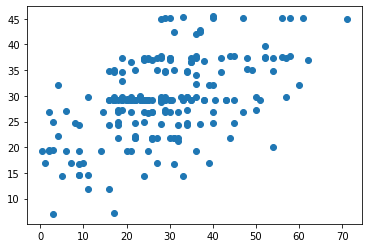

In [51]:
plt.scatter(y_test, predictions)

In [52]:
print(metrics.mean_absolute_error(y_test, predictions))
print(metrics.mean_squared_error(y_test, predictions))
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print(metrics.explained_variance_score(y_test, predictions))

9.559718969013286
135.0280508009259
11.620157090200024
0.26777069626995886


In [53]:
#compare kde of age with predictions age

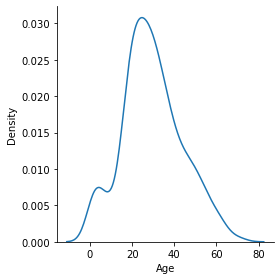

In [54]:
sns.displot(data=df,x='Age',kind='kde',height=4)

In [55]:
df['Age'].describe()

count    714.000000
mean      29.539454
std       14.163805
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       71.000000
Name: Age, dtype: float64

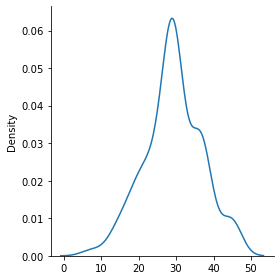

In [56]:
sns.displot(data=predictions, height=4,kind='kde')

In [57]:
pd.DataFrame(predictions).describe()
#print(np.mean(predictions))
#print(np.std(predictions))

,0
count,215.000000
mean,29.269684
std,7.657750
min,7.004127
25%,24.745456
50%,29.268895
75%,34.925577
max,45.502602


In [58]:
#na_filldf.head()
na_df.reset_index(inplace = True)
single_passenger = na_filldf.drop('index',axis=1).iloc[0]

NameError: name 'na_filldf' is not defined

In [ ]:
single_passenger = scaler.transform(single_passenger.values.reshape(-1,4))

In [ ]:
lm.predict(single_passenger)